## 图表示学习代码

虽然我们讲解了许多表示学习的方法，一种更简单的方法是：我们用数据集的标签来直接监督嵌入两两节点的嵌入。比如，使用边分类任务，我们通过最大化正边的两个节点的点积，我们也可以学习到一个很好的嵌入。

下面，我们将通过边分类为正或负的任务，来完成一个节点表示/嵌入学习。

我们将使用 Karate Club Network 空手道俱乐部网络，描述了空手道俱乐部 34 名成员的社交网络，并记录了在俱乐部外互动的成员之间的链接。

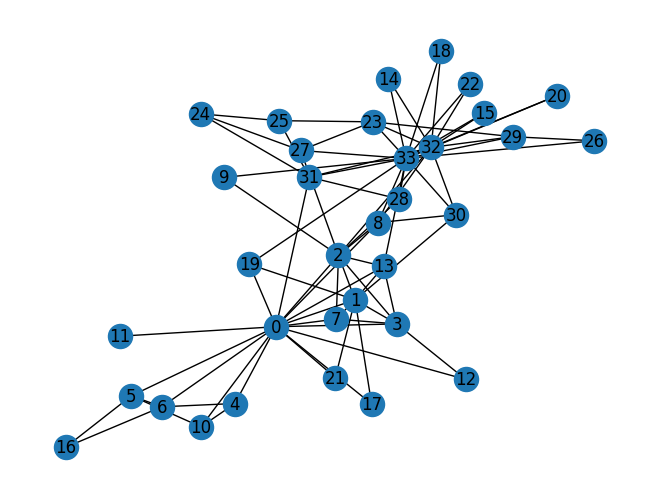

In [4]:
import networkx as nx
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 载入空手道俱乐部网络
G = nx.karate_club_graph()
# 可视化图
nx.draw(G, with_labels = True)


随机初始化嵌入：

-   我们希望空手道俱乐部网络中的每个节点都有 16 维向量。
-   我们要初始化均匀分布的矩阵，范围为 [0,1)[0,1)，使用 torch.rand。

可视化嵌入：将Embedding用PCA降维到二维，再将两类节点的嵌入的二维表示分别以红色和蓝色画出点。

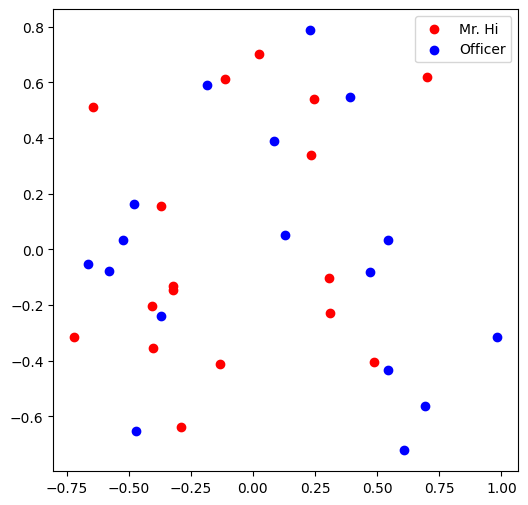

In [5]:
torch.manual_seed(1)

# 初始化嵌入函数
def create_node_emb(num_node=34, embedding_dim=16):
  emb=nn.Embedding(num_node,embedding_dim) # 创建 Embedding
  emb.weight.data=torch.rand(num_node,embedding_dim) # 均匀初始化
  return emb

# 初始化嵌入
emb = create_node_emb()

# 可视化
def visualize_emb(emb):
  X = emb.weight.data.numpy()
  pca = PCA(n_components=2)
  components = pca.fit_transform(X)
  plt.figure(figsize=(6, 6))
  club1_x = []
  club1_y = []
  club2_x = []
  club2_y = []
  for node in G.nodes(data=True):
    if node[1]['club'] == 'Mr. Hi':
    #node的形式：第一个元素是索引，第二个元素是attributes字典
      club1_x.append(components[node[0]][0])
      club1_y.append(components[node[0]][1])
      #这里添加的元素就是节点对应的embedding经PCA后的两个维度
    else:
      club2_x.append(components[node[0]][0])
      club2_y.append(components[node[0]][1])
  plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
  plt.scatter(club2_x, club2_y, color="blue", label="Officer")
  plt.legend()
  plt.show()

# 可视化初始嵌入
visualize_emb(emb)

我们将使用**边分类为正或负的任务**来完成表示学习。

获取负边和正边。正边是图中存在的边，存放在 `pos_edge_list` 中。

In [6]:
def graph_to_edge_list(G):
  # 将 tensor 变成 edge_list

  edge_list = []

  for edge in G.edges():
    edge_list.append(edge)

  return edge_list

def edge_list_to_tensor(edge_list):
  # 将 edge_list 变成 tesnor

  edge_index = torch.tensor([])

  edge_index=torch.LongTensor(edge_list).t()

  return edge_index

pos_edge_list = graph_to_edge_list(G)
pos_edge_index = edge_list_to_tensor(pos_edge_list)
print("The pos_edge_index tensor has shape {}".format(pos_edge_index.shape))
print("The pos_edge_index tensor has sum value {}".format(torch.sum(pos_edge_index)))


The pos_edge_index tensor has shape torch.Size([2, 78])
The pos_edge_index tensor has sum value 2535


负边：图中不存在的边，即两个节点之间在真实图中没有连线的边。抽样一定数目不存在的边作为负值的边。

In [7]:
import random

# 采样负边
def sample_negative_edges(G, num_neg_samples):

  neg_edge_list = []

  # 得到图中所有不存在的边（这个函数只会返回一侧，不会出现逆边）
  non_edges_one_side = list(enumerate(nx.non_edges(G)))
  neg_edge_list_indices = random.sample(range(0,len(non_edges_one_side)), num_neg_samples)
  # 取样num_neg_samples长度的索引
  for i in neg_edge_list_indices:
    neg_edge_list.append(non_edges_one_side[i][1])

  return neg_edge_list

# Sample 78 negative edges
neg_edge_list = sample_negative_edges(G, len(pos_edge_list))

# Transform the negative edge list to tensor
neg_edge_index = edge_list_to_tensor(neg_edge_list)
print("The neg_edge_index tensor has shape {}".format(neg_edge_index.shape))


The neg_edge_index tensor has shape torch.Size([2, 78])


给定一条边和每个节点的嵌入，嵌入的点积，后跟一个 sigmoid，应该给出该边为正（sigmoid 的输出 > 0.5）或负（sigmoid 的输出 < 0.5）的可能性。训练目标：使有边连接（pos_edge_index）的节点嵌入点乘结果趋近于1，无边连接的趋近于0。

loss_result 0.020122049376368523
Accuracy 1.0
loss_result 0.019838452339172363
Accuracy 1.0
loss_result 0.019307971000671387
Accuracy 1.0
loss_result 0.01871459372341633
Accuracy 1.0
loss_result 0.018121939152479172
Accuracy 1.0
loss_result 0.017550643533468246
Accuracy 1.0
loss_result 0.01700630970299244
Accuracy 1.0
loss_result 0.016489477828145027
Accuracy 1.0
loss_result 0.01599903777241707
Accuracy 1.0
loss_result 0.015533404424786568
Accuracy 1.0
loss_result 0.01509095449000597
Accuracy 1.0
loss_result 0.01467012707144022
Accuracy 1.0
loss_result 0.01426948606967926
Accuracy 1.0
loss_result 0.013887684792280197
Accuracy 1.0
loss_result 0.01352351251989603
Accuracy 1.0
loss_result 0.01317583303898573
Accuracy 1.0
loss_result 0.012843619100749493
Accuracy 1.0
loss_result 0.01252591423690319
Accuracy 1.0
loss_result 0.012221834622323513
Accuracy 1.0
loss_result 0.011930576525628567
Accuracy 1.0
loss_result 0.011651381850242615
Accuracy 1.0
loss_result 0.011383560486137867
Accuracy 1

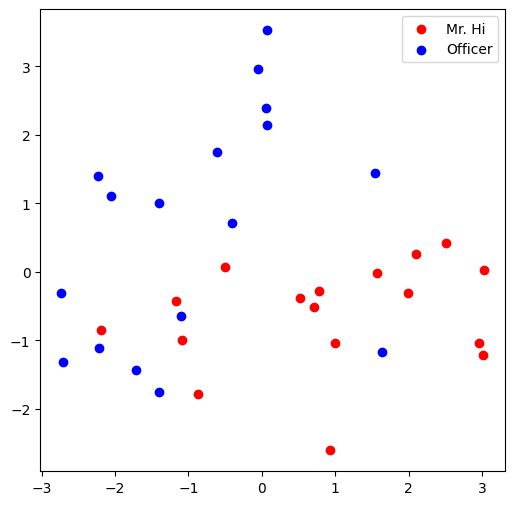

In [9]:
from torch.optim import SGD
import torch.nn as nn

def accuracy(pred, label):
  #题目要求：
  #输入参数：
  #  pred (the resulting tensor after sigmoid)
  #  label (torch.LongTensor)
  #预测值大于0.5被分类为1，否则就为0
  #准确率返回值保留4位小数
  
  #accuracy=预测与实际一致的结果数/所有结果数
  #pred和label都是[78*2=156]大小的Tensor
  accu=round(((pred>0.5)==label).sum().item()/(pred.shape[0]),4)
  return accu


def train(emb, loss_fn, sigmoid, train_label, train_edge):
  #题目要求：
  #用train_edge中的节点获取节点嵌入
  #点乘每一点对的嵌入，将结果输入sigmoid
  #将sigmoid输出输入loss_fn
  #打印每一轮的loss和accuracy

  epochs = 500
  learning_rate = 0.1

  optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)

  for i in range(epochs):
    optimizer.zero_grad()
    train_node_emb = emb(train_edge)  # [2,156,16]
    # 156是总的用于训练的边数，指78个正边+78个负边
    dot_product_result = train_node_emb[0].mul(train_node_emb[1])  # 点对之间对应位置嵌入相乘，[156,16]
    dot_product_result = torch.sum(dot_product_result,1)  # 加起来，构成点对之间向量的点积，[156]
    sigmoid_result = sigmoid(dot_product_result)  # 将这个点积结果经过激活函数映射到0,1之间
    loss_result = loss_fn(sigmoid_result,train_label)
    loss_result.backward()
    optimizer.step()
    if i%10==0: 
      print(f'loss_result {loss_result}')
      print(f'Accuracy {accuracy(sigmoid_result,train_label)}')


loss_fn = nn.BCELoss()
sigmoid = nn.Sigmoid()

# 生成正负样本标签
pos_label = torch.ones(pos_edge_index.shape[1], )
neg_label = torch.zeros(neg_edge_index.shape[1], )

# 拼接正负样本标签
train_label = torch.cat([pos_label, neg_label], dim=0)

# 拼接正负样本
# 因为数据集太小，我们就全部作为训练集
train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)

train(emb, loss_fn, sigmoid, train_label, train_edge)

# 训练后可视化
visualize_emb(emb)
